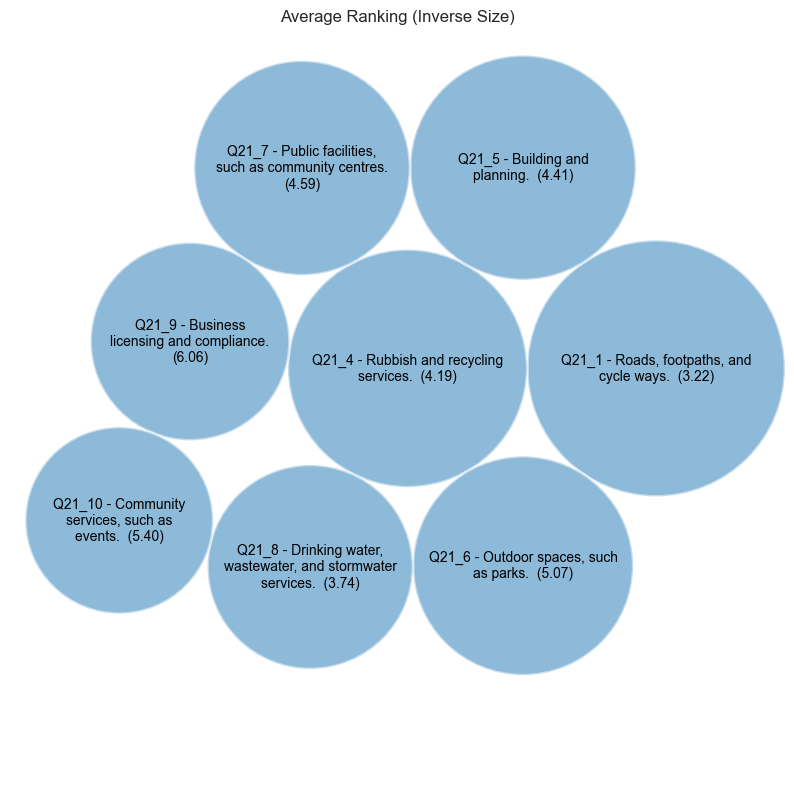

In [22]:
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import circlify
import textwrap

def visualise_column(df, column_name):
    """
    Visualises a single column (with comma-separated values) as bubbles based on the frequency of the entries.
    """
    global num_cols
    num_cols = df.shape[0]

    # Extract and clean the relevant column (removes "Other, please specify." if present)
    column = df[column_name].str.replace('Other, please specify.,', '', regex=False)

    # Split the column into individual entries (comma-separated values)
    column_split = column.str.split(r'\s,|(?<=[a-zA-Z.]),(?=[a-zA-Z])').explode().str.strip()

    # Simplify the text (you can add specific text-cleaning steps here if necessary)
    simplified_column = column_split.apply(simplify_text)

    # Count the occurrences of each unique entry
    column_counts = simplified_column.value_counts()

    # Generate the circles and plot
    circles, labels, column_counts, ax = setup_plot(column_name, column_counts)
    render_circles(circles, labels, column_counts, ax, 'percentage')

# Function to process and simplify each technology entry
def simplify_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Process the text using spaCy
    # doc = nlp(text)
    #
    # Keep original words that are not stop words, not punctuation, and have more than 1 character
    # simplified_tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 1]

    # Return the simplified sentence (joined back together)
    # return " ".join(simplified_tokens)
    return text

def setup_plot(column_name, column_counts):
    """
    Prepares the plot by calculating circle positions based on counts.
    """
    # Compute circle positions based on the counts
    circles = circlify.circlify(
        column_counts.tolist(),
        show_enclosure=False,
        target_enclosure=circlify.Circle(x=0, y=0, r=1)
    )

    # Reverse the circles to match the order of data
    circles = circles[::-1]

    # Create a figure and subplot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Set the title
    ax.set_title(column_name)

    # Remove axes from the plot
    ax.axis('off')

    # Find axis boundaries
    lim = max(
        max(
            abs(circle.x) + circle.r,
            abs(circle.y) + circle.r,
        )
        for circle in circles
    )
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

    # Labels for the circles (unique values in the column)
    labels = column_counts.index

    return circles, labels, column_counts, ax

def render_circles(circles, labels, column_counts, ax, format_type='percentage'):
    """
    Renders the circles (bubbles) with labels.
    """
    # Loop through each circle and label
    for circle, label, count in zip(circles, labels, column_counts):
        # Calculate the percentage of occurrences for the frequency-based visualization
        if format_type == 'percentage':
            percentage = count / num_cols * 100
            wrapped_label = textwrap.fill(f"{label}\n({percentage:.1f}%)", width=int(2 * circle.r * 50))
        elif format_type == 'ranking':
            # For rankings, display the actual average ranking value
            wrapped_label = textwrap.fill(f"{label}\n({1/count:.2f})", width=int(2 * circle.r * 50))

        # Get circle properties (x, y, radius)
        x, y, r = circle

        # Draw the circle
        ax.add_patch(plt.Circle((x, y), r, alpha=0.5, linewidth=2))

        # Annotate the circle with the wrapped label
        plt.annotate(
            wrapped_label,
            (x, y),
            va='center',
            ha='center',
            fontsize=10,  # Font size
            color='black'
        )

    # Display the plot
    plt.show()

def visualise_ranked_columns(df, columns):
    """
    Visualises bubbles based on **inverse** of average rankings for each category,
    while keeping the label as the **actual** average ranking.
    """
    global num_cols
    num_cols = df.shape[0]

    # Compute the average ranking for each category (column)
    average_rankings = [df[column_name].mean() for column_name in columns]

    # Take the inverse of the rankings for bubble size (lower rankings => bigger circles)
    inverse_rankings = [1 / avg for avg in average_rankings]

    # Create a Series with the inverse rankings and corresponding column labels
    column_counts = pd.Series(inverse_rankings, index=columns)

    # Generate the circles and plot
    circles, labels, column_counts, ax = setup_plot("Average Ranking", column_counts)
    render_circles(circles, labels, column_counts, ax, 'ranking')

# # Read the CSV file (replace with the correct path)
# df = pd.read_csv('data/all-responses.csv')
#
# # Visualise the single-column data (comma-separated values)
# # visualise_column(df, 'Q4 - What technology would you like to see more of in our community? *\n\nPlease t...')
#
# # List of columns representing rankings
# columns = ['Q21_1 - Roads, footpaths, and cycle ways. ',
#        'Q21_4 - Rubbish and recycling services. ',
#        'Q21_5 - Building and planning. ',
#        'Q21_6 - Outdoor spaces, such as parks. ',
#        'Q21_7 - Public facilities, such as community centres.  ',
#        'Q21_8 - Drinking water, wastewater, and stormwater services. ',
#        'Q21_9 - Business licensing and compliance. ',
#        'Q21_10 - Community services, such as events. ']
# # Visualise the ranked data (inverse of average ranking for bubble size)
# visualise_ranked_columns(df, columns)
